In [ ]:
!pip install razdel==0.5
!pip install pymorphy2==0.8

     |████████████████████████████████| 46 kB 2.6 MB/s 
     |████████████████████████████████| 7.1 MB 20.5 MB/s 


In [ ]:
import numpy as np
import pandas as pd

from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier

from tqdm import tqdm_notebook
from gensim.models import Word2Vec
import razdel
import re
import pymorphy2
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer 

TOKEN_PATTERN = "[а-яё]+"

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Считываем данные

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/train.csv")

train_df.head()

,id,url,title,target
0,0,m.kp.md,"Экс-министр экономики Молдовы - главе МИДЭИ, ц...",False
1,1,www.kp.by,Эта песня стала известна многим телезрителям б...,False
2,2,fanserials.tv,Банши 4 сезон 2 серия Бремя красоты смотреть о...,False
3,3,colorbox.spb.ru,Не Беси Меня Картинки,False
4,4,tula-sport.ru,В Новомосковске сыграют следж-хоккеисты алекси...,False


In [ ]:
test_df = pd.read_csv("/content/drive/MyDrive/test.csv")

test_df.head()

,id,url,title
0,135309,www.kommersant.ru,Шестой кассационный суд в Самаре начнет работу...
1,135310,urexpert.online,"Что такое индексация алиментов, кем и в каких ..."
2,135311,imperimeha.ru,Женщинам | Империя Меха - Part 12
3,135312,national-porn.com,"Небритые, волосатые киски: Порно всех стран и ..."
4,135313,2gis.ru,67


In [ ]:
len(test_df), len(train_df)

(165378, 135309)

In [ ]:
train_df["target"].value_counts()

False    118594
True      16715
Name: target, dtype: int64

Небольшая проверка данных

(67.0, 63.0)

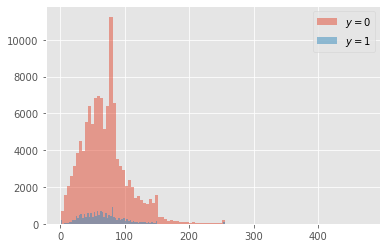

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

title_len_0 = train_df.loc[train_df['target'] == 0, 'title'].str.len().values
title_len_1 = train_df.loc[train_df['target'] == 1, 'title'].str.len().values

bins=100
alpha=0.5

plt.hist(title_len_0, alpha=alpha, bins=bins, label=r'$y = 0$')
plt.hist(title_len_1, alpha=alpha, bins=bins, label=r'$y = 1$')
plt.legend();
np.median(title_len_0), np.median(title_len_1)

*Медианы примерно равны, значит не будем добавлять признак по длине запроса*

Лемматизация

In [ ]:
lemmatizer_ru = pymorphy2.MorphAnalyzer()
lemmatizer_en = WordNetLemmatizer()

stopword_set_ru = set(nltk.corpus.stopwords.words('russian'))
stopword_set_en = set(nltk.corpus.stopwords.words('english'))
stopword_set = stopword_set_ru.union(stopword_set_en)

In [ ]:
def lemmatize(token):
  lemmatizer_cache = {}
  if lemmatizer_ru.word_is_known(token):
    if token not in lemmatizer_cache:
      lemmatizer_cache[token] = lemmatizer_ru.parse(token)[0].normal_form
      return lemmatizer_cache[token]
  return token

In [ ]:
def tokenize(text):
    return re.findall(TOKEN_PATTERN, text.lower())

Предобработка запросов

In [ ]:
from tqdm.notebook import tqdm
def prepare_sentence_dataset(documents):
  tokenized_sentences = []
  for sentence in tqdm(documents):
    lemmatized_tokens = [lemmatizer_en.lemmatize(token) for token in nltk.word_tokenize(sentence.lower())]
    lemmatized_tokens = [lemmatize(token) for token in lemmatized_tokens]
    tokenized_sentences.append(' '.join([token for token in lemmatized_tokens if token not in stopword_set]))
  return tokenized_sentences

train_df['title_prepare'] = prepare_sentence_dataset(train_df.title.values)
test_df['title_prepare'] = prepare_sentence_dataset(test_df.title.values)

  0%|          | 0/135309 [00:00<?, ?it/s]

  0%|          | 0/165378 [00:00<?, ?it/s]

In [ ]:
y_train = train_df["target"].astype(int).values
del train_df['target'], train_df['title'], train_df['id'], test_df['title']

**Реализация**

Формируем пайп с предобработкой и классификатором

In [ ]:
pipeline = Pipeline([
    ('features', ColumnTransformer([
            ('url', TfidfVectorizer(analyzer='word', max_df=0.75, 
                                      sublinear_tf = True, strip_accents = 'unicode'), 
             'url'),
            ('title_prepare', TfidfVectorizer(analyzer='word', max_df = 0.5, 
                                              stop_words = stopword_set, 
                                              binary = True, sublinear_tf = True, 
                                              strip_accents = 'unicode'),
             'title_prepare'),
            ])
    ),
    ('clf', BaggingClassifier(base_estimator=MultinomialNB(alpha = 0.1444444444), 
                              n_jobs = -1, random_state=42))
])

Задаем параметры для GridSearchCV (alpha в MultinomialNB был подобран ранее аналогичным образом )

In [ ]:
parameters = {'features__title_prepare__ngram_range': ((1, 4), (1, 5), (2, 4)),
              'features__url__ngram_range': ((1, 4), (2, 3), (2, 4))}

Треним с кросс-валидацией

In [ ]:
gcv_model = GridSearchCV(pipeline, parameters, cv = 3, n_jobs = -1, verbose=2)
gcv_model.fit(train_df, y_train)

Устанавливаем лучшую модель

In [ ]:
model = gcv_model.best_estimator_

Результаты GridSearchCV

In [ ]:
gcv_model.cv_results_

{'mean_fit_time': array([152.48469512, 147.54007316, 178.66498788, 176.18469683,
        116.55651991, 102.62128019]),
 'mean_score_time': array([4.41903528, 4.4438115 , 4.73052414, 4.6987683 , 3.85117133,
        2.88881024]),
 'mean_test_score': array([0.95395724, 0.96578942, 0.95354337, 0.96711231, 0.93682608,
        0.95409027]),
 'param_features__title_prepare__ngram_range': masked_array(data=[(1, 3), (1, 3), (1, 4), (1, 4), (2, 3), (2, 3)],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_features__url__ngram_range': masked_array(data=[(1, 3), (2, 3), (1, 3), (2, 3), (1, 3), (2, 3)],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'features__title_prepare__ngram_range': (1, 3),
   'features__url__ngram_range': (1, 3)},
  {'features__title_prepare__ngram_range': (1, 3),
   'features__url__ngram_range': (2, 3)},
  {'features__tit

In [ ]:
y_pred = model.predict(train_df)
print(f'Train score : {f1_score(y_train, y_pred)}')

Train score : 0.9722760646108664


Формируем csv с ответами

In [ ]:
test_df["target"] = model.predict(test_df).astype(bool)

test_df[["id", "target"]].to_csv("/content/drive/MyDrive/ml_baseline_trenev.csv", index=False)

!cat /content/drive/MyDrive/ml_baseline_trenev.csv | head

id,target
135309,False
135310,False
135311,False
135312,True
135313,False
135314,False
135315,False
135316,False
135317,False
